# DAE Mini Assignment
## Analysing the relationship between the production of coal and the amount of electricity generated in South Africa

### Abstract
This notebook presents data exploration and analysis of coal production and power generated to determine if the previous month's coal production significantly affects the current amount of power generated in South Africa and if so, what the relationship between the datasets is. We identified that the coal production data had seasonality by plotting the data and performing the Augmented Dickey-Fuller test (ADF). We decomposed the data into its seasonal, trend, and residual attributes. Once we removed the seasonal attribute, we fitted the datasets to a linear regression model. The results from the linear regression model allowed residual analysis, which determined that the linear regression model was an appropriate choice. Lastly, a correlation coefficient hypothesis test was conducted to verify the population relationship between the two datasets. It was concluded that the previous month's coal production significantly affects the power generated in South Africa and that the relationship is linear.

### Introduction
Many factors influence the amount of electricity that can be generated in a country. Some of these include the number of available generators, the price of resources, such as coal and oil, and the amount of coal and oil produced. The purpose of this notebook is to answer the question: "Does the pervious months coal production significantly affect the current amount of power generated in South Africa?" To do this, the data will go through analysis and exploration to determine if there is a relationship and, if so, what the relationship is.

To achieve this, we will first look at the plotted data for coal production (Actual Coal Index) and the data for power generated (Total Electricity Generated). This will allow us to look at the overall movement of the data. We adopt the autocorrelation graph to get a better idea of the trends and seasonality which may occur in the time series data. If there is an indication of seasonality or trend, a test for stationarity will be implemented to check if the seasonality or trend is still present after adjustments are made. Once both datasets are stationary, we will split the data into training and testing data; fitting the training data to the model. The testing data is then used to evaluate the model. Afterwards, the predicted values will be employed for residual analysis to determine if the correct type of model was chosen; creating a hypothesis in the process. Lastly, the hypothesis is tested using hypothesis testing related to the Pearson Correlation Coefficient.

Following the data wrangling, is the section on exploratory analysis. This section explores the data and presents analysis both visually and statistically. The last two sections are the results section, where the results from the analysis section are summarised and discussed, and the conclusion section, which presents possible improvement for future work and research.



### The Data
The first dataset that will be used in this notebook contains information on the production and sales of the mining industry. This information was collected (up to, and including, December 2019) by surveying the Department of Mineral Resources and Energy (DMRE) and was published on 13 February 2020. The dataset can be found [here](http://www.statssa.gov.za/?page_id=1854&PPN=P2041&SCH=7550) (downloaded on 21 February 2020). In the 44x214 table, the physical volume of mining production (actual indexes and seasonally adjusted indexes), as well as mineral sales for all the resources mined by South Africa, can be found. This helps in answering the question as we can use the actual physical volume of mining production index for coal.

The second dataset contains data on electricity generated and available for distribution. The data was collected by statsSA (up to, and including, December 2019) through surveying establishments in the electricity industry. This dataset can be found [here](http://www.statssa.gov.za/?page_id=1854&PPN=P4141&SCH=7546) (downloaded on 21 February 2020). The 24x251 table contains information ranging from the total available electricity generated in South Africa to the amount of electricity distributed to each province. To answer the question at hand, we will be looking at the total generated in all of South Africa.

The quality of the data is high as it is valid, complete, consistent, uniform and assumed to be accurate as it has been take from a governmental site.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.power import TTestIndPower

from scipy.stats import pearsonr
from scipy.stats import t

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

sns.set(palette='deep', style='white')
pd.set_option('display.notebook_repr_html', True)

### Load Data

#### Electricity

In [2]:
#Data for Electricity
power_series = pd.read_excel('Electricity from 2000.xlsx')
display(power_series.head())

H01                                                H02       H03  \
0  P4141  Electricity generated and available for distri...  ELEKTS10   
1  P4141  Electricity generated and available for distri...  ELEKIN11   
2  P4141  Electricity generated and available for distri...  ELEKIS11   
3  P4141  Electricity generated and available for distri...  ELEKTR11   
4  P4141  Electricity generated and available for distri...  ELEKTR13   

                                         H04  \
0                      Total - All producers   
1  Physical volume of electricity production   
2  Physical volume of electricity production   
3                      Total - All producers   
4                      Total - All producers   

                                                 H05  H13  H14  \
0  Electricity available for distribution in Sout...  NaN  NaN   
1                                                NaN  NaN  NaN   
2                                                NaN  NaN  NaN   
3                               Electricity produced  NaN  NaN   
4            Purchased outside South Africa (import)  NaN  NaN   

                   H16             H17             H18  ... MO032019  \
0  Seasonally adjusted  Gigawatt-hours             NaN  ...  18751.0   
1                  NaN           Index  Base: 2015=100  ...    100.4   
2  Seasonally adjusted           Index  Base: 2015=100  ...     99.7   
3                  NaN  Gigawatt-hours             NaN  ...  20943.0   
4                  NaN  Gigawatt-hours             NaN  ...    707.0   

   MO042019  MO052019  MO062019  MO072019  MO082019  MO092019  MO102019  \
0   19309.0   19229.0   19073.0   18961.0   18463.0   19066.0   18961.0   
1      99.4     105.9     105.2     108.1     103.0      99.6     103.4   
2     102.9     102.2     102.6     101.2      99.2     101.5     100.4   
3   20733.0   22090.0   21947.0   22552.0   21500.0   20781.0   21571.0   
4     689.0     888.0     692.0     825.0     766.0     817.0     900.0   

   MO112019  MO122019  
0   18664.0   18419.0  
1      99.0      94.1  
2      99.3      97.7  
3   20653.0   19640.0  
4     903.0     953.0  

[5 rows x 251 columns]

#### Coal

In [3]:
#Data for Mineral Production
coal_series = pd.read_excel('Coal from 2003.xlsx')
display(coal_series.head())

H01                           H02       H03  \
0  P2041  Mining: Production and sales  FMP20000   
1  P2041  Mining: Production and sales  FMP20001   
2  P2041  Mining: Production and sales  FMP21000   
3  P2041  Mining: Production and sales  FMP23010   
4  P2041  Mining: Production and sales  FMP23020   

                                    H04                   H05  H06  \
0  Physical volume of mining production  Total, gold included  NaN   
1  Physical volume of mining production  Total, gold excluded  NaN   
2  Physical volume of mining production                  Coal  NaN   
3  Physical volume of mining production              Iron ore  NaN   
4  Physical volume of mining production              Chromium  NaN   

              H16    H17       H18      H25  ...  MO032019  MO042019  \
0  Actual indices  Index  2015=100  Monthly  ...      97.0      90.6   
1  Actual indices  Index  2015=100  Monthly  ...     103.3      95.9   
2  Actual indices  Index  2015=100  Monthly  ...     104.8      95.5   
3  Actual indices  Index  2015=100  Monthly  ...      93.8      90.7   
4  Actual indices  Index  2015=100  Monthly  ...     110.9     112.4   

   MO052019  MO062019  MO072019  MO082019  MO092019  MO102019  MO112019  \
0     103.1     107.5      98.5     102.5     101.9     103.7     101.8   
1     110.2     113.6     103.1     106.6     105.8     107.8     105.8   
2     112.0     105.7     112.2     109.1     101.3     107.3     102.5   
3     105.6     122.0      98.5      95.1     109.9      97.7     107.5   
4     119.0     120.6     116.6     117.8     114.0     124.2     121.7   

   MO122019  
0      94.2  
1      97.6  
2      77.6  
3     117.4  
4     105.3  

[5 rows x 214 columns]

It is clear to see that the data is very untidy and almost unreadable in its current state. To fix this, both tables are transposed so that the dates can be the rows, and then the data frame is spliced so that they only have the information we require. In this case, we need the total electricity generated from the power table and the actual physical volume of mining production from the coal table. The labels for the months are renamed for readability and then converted to a datetime type and the numerical data is converted to float64.

In [4]:
#Selects the information we want from the data table
power_df = pd.DataFrame(power_series.T[11:][0].rename('Total Electricity Generated (GWh)'))
#Changes the date text into a more readable form (YYYY-MM-DD)
power_df['Date'] = power_df.index.map(lambda s: s[4:] + '-' + s[2:4] + '-01')
power_df['Date'] = pd.to_datetime(power_df['Date'])
#Reset the Index and drop old date format
power_df.reset_index(inplace = True,drop = True)
#Rearrange columns so Date is first
power_df = power_df[['Date','Total Electricity Generated (GWh)']]
#Change data type of Total Electricity Generated
power_df['Total Electricity Generated (GWh)'] = power_df['Total Electricity Generated (GWh)'].astype(float)

display(power_df.head())
display(power_df.info())

Date  Total Electricity Generated (GWh)
0 2000-01-01                            15916.0
1 2000-02-01                            15981.0
2 2000-03-01                            16106.0
3 2000-04-01                            16347.0
4 2000-05-01                            16329.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
Date                                 240 non-null datetime64[ns]
Total Electricity Generated (GWh)    240 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


None

In [5]:
#Selects the information we want from the data table
coal_df = pd.DataFrame(coal_series.T[10:][2].rename('Actual Coal Index'))
#Changes the date text into a more readable form (YYYY-MM-DD)
coal_df['Date'] = coal_df.index.map(lambda s: s[4:] + '-' + s[2:4] + '-01')
coal_df['Date'] = pd.to_datetime(coal_df['Date'])
#Reset the Index and drop old date format
coal_df.reset_index(inplace = True,drop = True)
#Rearrange columns so Date is first
coal_df = coal_df[['Date','Actual Coal Index']]
#Change data type of Coal Index
coal_df['Actual Coal Index'] = coal_df['Actual Coal Index'].astype(float)


display(coal_df.head())
display(coal_df.info())

Date  Actual Coal Index
0 2003-01-01               86.5
1 2003-02-01               82.9
2 2003-03-01               87.9
3 2003-04-01               89.7
4 2003-05-01              101.8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
Date                 204 non-null datetime64[ns]
Actual Coal Index    204 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB


None

The data is now easier to read compared to the raw data and can now be analysed.

In [6]:
#Making both data sets equal size. 
#Coal starting 1 month before electricity and electricty ending 1 month after
if np.shape(power_df) != np.shape(coal_df):
    #Drop all entries before 2003-02-01
    power_df = power_df.drop(range(37)).dropna()
    #Drop last entry
    coal_df = coal_df.drop(len(coal_df)-1)
    #Make indices the same for joining
    power_df.index = coal_df.index
    #Make Dates the same for simplicity
    coal_df.Date = power_df.Date #Decide whether to do this or not
    
display(coal_df.head(1),power_df.head(1))


Date  Actual Coal Index
0 2003-02-01               86.5

Date  Total Electricity Generated (GWh)
0 2003-02-01                            17516.0

For this notebook, we will be looking at the previous month's coal production and comparing it to the current month's electricity generated. For simplicity, the dates of the previous month's coal production will be the same as the dates of the current month's electricity generated.

In [7]:
#Combining the two data sets into one
comb_df = power_df.merge(coal_df, how = 'outer', sort=True)
display(comb_df.head())

Date  Total Electricity Generated (GWh)  Actual Coal Index
0 2003-02-01                            17516.0               86.5
1 2003-03-01                            17690.0               82.9
2 2003-04-01                            17547.0               87.9
3 2003-05-01                            17429.0               89.7
4 2003-06-01                            17751.0              101.8

### Exploratory Analysis


In [8]:
#Calculating the correlation coefficient
correlM = comb_df.corr()
print('The correlation coefficient of the data is ', correlM.loc['Actual Coal Index'][0] )

The correlation coefficient of the data is  0.23235245004885702


The correlation coefficient shows that the production of coal and the power generated in South Africa have a weak positive relationship. Even though the relationship is weak, it still shows that there is a correlation and that there is cause for comparing the datasets and answering the question.

In [9]:
#Plotting the two data sets on the same set of axes
ax = comb_df.plot(x = 'Date',y = ['Actual Coal Index','Total Electricity Generated (GWh)'],secondary_y = ['Total Electricity Generated (GWh)'], color = ['Black','Blue'], figsize = (12,8))
ax.set_ylabel('Actual Coal Index',fontsize = 14, color = 'black')
ax.right_ax.set_ylabel('Total Electricity Generated (GWh)',fontsize = 14, color = 'Blue')
plt.title('Coal Production (Previous Month) vs Total Electricity Generated (Current Month)\n 2003-2019')
plt.show()

Plotting the two data sets in the figure above visually shows us that they are correlated since both plots are quite similar. The graph also shows us that both data sets experience regular fluctuations every calendar year. This is known as seasonality and may be the cause for the low correlation coefficient of the two data sets.

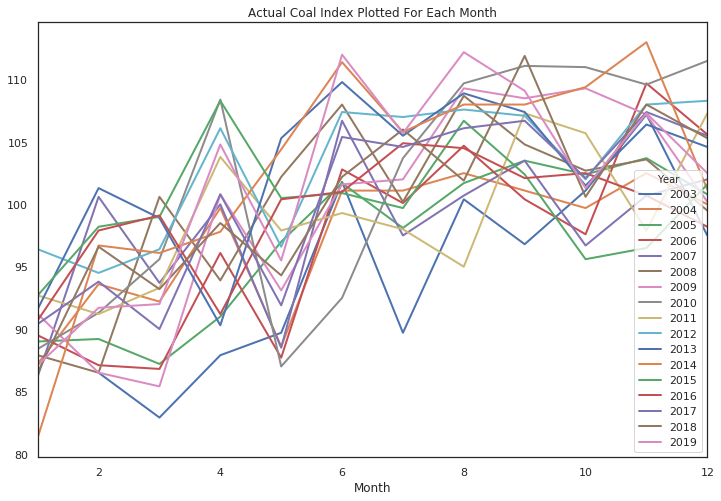

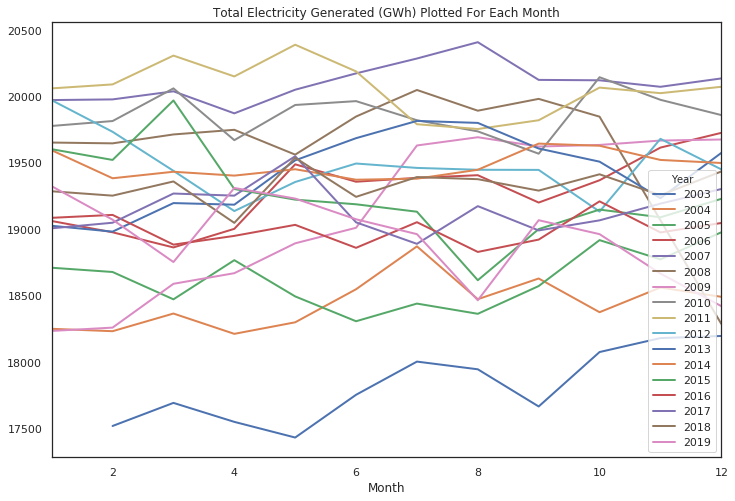

In [10]:
#Creating a table which contains the value for each month and year
season = comb_df.copy()
season['Date'] = comb_df['Date']
season['Month'] = comb_df['Date'].dt.month
season['Year'] = comb_df['Date'].dt.year

spivot = pd.pivot_table(season, index='Month', columns='Year', values = 'Actual Coal Index', aggfunc=np.mean)
spivot.plot(figsize=(12,8), linewidth=2, title = 'Actual Coal Index Plotted For Each Month')
plt.show()

spivot = pd.pivot_table(season, index='Month', columns='Year', values = 'Total Electricity Generated (GWh)')
spivot.plot(figsize=(12,8), linewidth=2, title = 'Total Electricity Generated (GWh) Plotted For Each Month')

plt.show()

For the *Actual Coal Index* graph it is easy to see a recurring pattern in certain months, but harder in others. For the *Total Electricity Generated (GWh)* graph, no obvious trend can be seen. For this reason a more definitive method is required to determine the seasonality. We next look at the autocorrelation graph for both *Actual Coal Index* and *Total Electricity Generated (GWh)*.

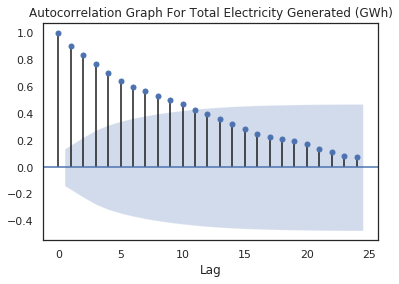

In [11]:
#Autocorrelation plots
plot_acf(comb_df.groupby('Date')['Date','Actual Coal Index'].mean().dropna(), title = 'Autocorrelation Graph For Actual Coal Index')
plt.xlabel('Lag')
plt.show()
plot_acf(comb_df.groupby('Date')['Date','Total Electricity Generated (GWh)'].mean().dropna(), title = 'Autocorrelation Graph For Total Electricity Generated (GWh)')
plt.xlabel('Lag')
plt.show()

The shaded blue represents the area considered to be insignificant. The oscillation which occurs for the *Actual Coal Index* is due to the seasonality of the data. This verifies that the data indeed experiences seasonal trends. The *Total Electricity Generated (GWh)* shows that there is a trend in the data since the gradient decreases as the lags increase. in order to deal with the seasonality and trends of the data, this uses a more mathematical approach. That is, we use the ADF to test for the stationarity of the data and make adjustments as such

A [stationary time series](https://people.duke.edu/~rnau/411diff.htm) is one whose statistical properties (mean, variance, ect.) do not change over time. Thus time series data which contains seasonality or trends is not stationary. For this reason we adopt the **Augmented Dickey-Fuller test (ADF)** which will allow us to objectively detect if the time series data has seasonality or trends as well as determine if we have removed said problems. ADF uses an autoregressive model and optimizes an information criterion across multiple different lag values. The hypotheses for the test are as follows:

* Null Hypothesis $H_0$: The time series has a unit root (i.e. the time series is not stationary)

* Alternative Hypothesis $H_1$: The time series does not have a unit root (i.e. the time series is stationary)

For this test a confidence level of 95% is used. This mean that if the p-value from the test is less than or equal to 5% we reject the null hypothesis, otherwise a p-value greater than 5% suggests we fail to reject the null hypothesis.

In [12]:
#Perform the ADF test and print results
def test_stationary(df):
    print ('Results of Dickey-Fuller Test:')
    #Fit data to the ADF test
    dftest = adfuller(df, autolag = 'AIC'  )
    #Extract results from test
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #Display results
    print (dfoutput)

In [13]:
print('Coal\n')
test_stationary(comb_df['Actual Coal Index'])
print('\nPower\n')
test_stationary(comb_df['Total Electricity Generated (GWh)'])

Coal

Results of Dickey-Fuller Test:
Test Statistic                  -2.590001
p-value                          0.095082
#Lags Used                      11.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64

Power

Results of Dickey-Fuller Test:
Test Statistic                  -3.363194
p-value                          0.012279
#Lags Used                       0.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64


After performing the ADF test, the p-value for *Actual Coal Index* is 0.0951 which is greater than the confidence level, therefore we faile to reject the null hypothesis, thus the data is not stationary. With a p-value of 0.0123, we successfully reject the null hypothesis and conclude that the *Total Electricity Generated (GWh)*. Since *Actual Coal Index* is non-stationary we decompose the time series data into its seasonal, trend, and residual attributes with the assumption that the components are multiplicative. The seasonal attribute is then removed from the original data.

In [14]:
#Decompose time series data into attributes
coal_season = seasonal_decompose(comb_df.set_index('Date')['Actual Coal Index'],model = 'mul')
#Remove seasonal attribute from original data
comb_df['Adjusted Coal Index'] = (comb_df.set_index('Date')['Actual Coal Index']/coal_season.seasonal).to_numpy()

In [15]:
print('Adjusted Coal Index\n')
test_stationary(comb_df['Adjusted Coal Index'])

Adjusted Coal Index

Results of Dickey-Fuller Test:
Test Statistic                  -5.605424
p-value                          0.000001
#Lags Used                       2.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


With the adjustment to the *Actual Coal Index*, the data is retested and this time the p-value is less than 5%. Therefore the null hypothesis is successfully rejected and stationarity has been achieved. Below is a graph showing the original data vs the newly adjusted data.

In [16]:
#Plotting the two data sets on the same set of axes
ax = comb_df.plot(x = 'Date',y = ['Actual Coal Index','Adjusted Coal Index'], color = ['grey','blue'], figsize = (12,8))
# ax.set_ylabel('Actual Coal Index',fontsize = 14, color = 'black')
plt.title('Actual Coal Index and Adjusted Coal Index')
plt.show()

In [17]:
#Check there are no null values
comb_df.isnull().sum()

Date                                 0
Total Electricity Generated (GWh)    0
Actual Coal Index                    0
Adjusted Coal Index                  0
dtype: int64

In [18]:
comb_df.corr()

Total Electricity Generated (GWh)  \
Total Electricity Generated (GWh)                           1.000000   
Actual Coal Index                                           0.232352   
Adjusted Coal Index                                         0.326711   

                                   Actual Coal Index  Adjusted Coal Index  
Total Electricity Generated (GWh)           0.232352             0.326711  
Actual Coal Index                           1.000000             0.668999  
Adjusted Coal Index                         0.668999             1.000000

After recalculating the correlations, we see that the adjustment has improved the relationship bewtween the coal index and the electricity generated from 0.2324 to 0.3267.

### Linear Regression

Now that both datasets are stationary, we can perform the model fitting. For this notebook, the relationship assumed between coal production and power generated is linear. We model the data with this assumption using the simple linear regression model. This model is suitable for the data since it models one independent variable to one dependent variable, coal production and power generated respectively. The data is modeled, by linear regression, to fit the following equation:
$$Y_i=\beta_{0}+\beta_{1} X_i$$

The records for each dataset is split into 70% training data, to fit the model, and 30% testing data, to verify the data, with the use of the python library *sklearn*. After the model is fitted, the predicted values will be subtracted from the actual test values and plotted. From this plot, we will be able to identify if linear regression is an appropriate model by looking at the spread of the residual data points. If the plot is randomly dispersed, then the linear regression model was a sound choice. If the points form a non-linear shape, then a non-linear model is more appropriate.

In [19]:
#Adjust data for correct shape
x = comb_df[['Date','Adjusted Coal Index']].set_index('Date')
y = comb_df[['Date','Total Electricity Generated (GWh)']].set_index('Date').to_numpy().ravel()
#Split data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33, random_state=42)
#Fit model
model = LinearRegression()
model.fit(x_train,y_train)
#Predict future values using test data
y_pred = model.predict(x_test)

#Plot Regression graph
plt.figure(figsize=(12,8))
plt.title("Linear Regression of Coal vs Electricity")
sns.regplot(x_test, y_test,color='blue')
#Plot line of predicted values
plt.plot(x_test, y_pred, color='red')
plt.ylabel("Total Electricity Generated (GWh)")
plt.xlabel("Adjusted Coal Index")
plt.legend(labels=['Line of best fit', 'Predictions'])
plt.show()
#Show Root mean sqaure error for traning and testing data
y_pred = model.predict(x_train)
print("\nRoot mean squared error for training data:",round(np.sqrt(mean_squared_error(y_train, y_pred)),4))
y_pred = model.predict(x_test)
print("Root mean squared error for testing data:",round(np.sqrt(mean_squared_error(y_test, y_pred)),4))


Root mean squared error for training data: 597.1032
Root mean squared error for testing data: 539.2719


The root mean sqared errors for both training and testing data indicate the inaccuracy of the model. The graph also shows this, as both the line of best fit and the predicted point are far from the true values. Even though the model is inaccurate, it does not mean that the model chosen is incorrect. This is seen in the figure below, which presents the graph of the residual data. The reasons for the inaccuracies are discussed further in the Results section.

In [20]:
#Calculate residuals
residuals = y_test - y_pred
plt.figure(figsize=(12,8))
#Plot residuals
sns.residplot(x = x_test, y = residuals, color="Black")
plt.ylabel('Residuals')
plt.xlabel('Coal Test Data')
plt.title('Residual Plot')
plt.show()

The pattern created by the residual data is very random. This reveals that a linear regression model is appropriate for the original data. The assumption that coal produced and power generated have a linear relationship may be valid; however, we will need to test this theory using hypothesis testing.


### Hypothesis Testing

The correlation coefficient describes the strength of a linear relationship between variables in samples. If a different sample were obtained, the correlation coefficient would differ, leading to different results. In order to draw conclusions about the population, we perform a hypothesis test for the population correlation coefficient ($\rho$). This notebook uses the **t-test** for testing the coefficient and uses the following hypotheses:
* Null Hypothesis $H_0$: There is no correlation between the variable $(\rho = 0)$

* Alternative Hypothesis $H_1$: There is a correlation between the variables $(\rho \neq 0)$

The t-statistic is calculated using the [formula](https://online.stat.psu.edu/stat501/lesson/1/1.9): 

$$t^* = \frac{r\sqrt{n-2}}{\sqrt{1-r^2}}$$
where:

    r = the sample correlation coefficient (Calculated using the Pearson Correlation Coefficient)

    n = sample size

The resulting test statistic is then used to calculate the p-value by referring to a t-distribution with n-2 degrees of freedom. Similar to the ADF test, if the p-value is less than or equal to 5% then we successfully reject the null hypothesis in favour of the alternative hypothesis and conclude that the relationship between the variables in the population is linear with 95% confidence. If the p-value is greater than 5%, then we fail to reject the null hypothesis and conclude that the relationship between the variables in the population is non-linear with 95% confidence.

In [21]:
#Calculation of the Pearson correlation coefficient
r = pearsonr(comb_df['Adjusted Coal Index'].to_numpy(),comb_df['Total Electricity Generated (GWh)'].to_numpy())[0]
#Calculation of the test statistic
test_stat = (r*np.sqrt(len(comb_df['Adjusted Coal Index'].to_numpy())-2))/(np.sqrt(1-(r**2)))
#Calculation of the p-value
stati = t.sf(test_stat, df = (len(comb_df['Adjusted Coal Index'].to_numpy())-2))*2
#Printing results
print('Pearson Correlation Coefficient:',round(r,4))
print('Test statistic:',round(test_stat,4))
print('P-value:',stati)

Pearson Correlation Coefficient: 0.3267
Test statistic: 4.9009
P-value: 1.961280978474439e-06


Having calculated the p-value from the test statistic, it is obvious that the p-value is less than 0.05. Therefore we successfully reject the null hypothesis and conclude that there is sufficient evidence that the variables in the population have a linear relationship. The last step is to check the likelihood of a Type II error (i.e. accepting the null hypothesis when it is in fact, false). Power analysis is performed on the hypothesis, and the results follow.

In [22]:
#Perform power analysis
power_analysis = TTestIndPower()
power_level = power_analysis.power(effect_size=r, nobs1=len(comb_df['Adjusted Coal Index']), alpha = 0.05, alternative='two-sided', ratio=1 )
print('Power level of test:',round(100*power_level,4),'%')

Power level of test: 90.7203 %


A power level of 90.7% translates to a 9.3% chance of a Type II error occurring. The results from the hypothesis seem to coincide with the residual analysis performed in the previous section.

### Results

The purpose of this notebook is to answer the question "Does the pervious months coal production significantly affect the current amount of power generated in South Africa?" This was achieved by investigating the relationship between the two variables. The results indicate that coal production, when adjusted for seasonality, has a linear relationship with the amount of power generated in South Africa.

When first looking at the data, there was a correlation coefficient of 0.2323 between the two datasets. However, it was discovered that the *Actual Coal Index* dataset experienced seasonality. This was identified by plotting the data for each year against the occurring months as well as testing if the data was stationary. The ADF test confirmed that the coal production dataset was not stationary, indicating that there were trends and seasonality in the data. The *Actual Coal Index* was adjusted for its seasonality and was identified as stationary after being retested. This adjustment increased the correlation coefficient to 0.3267. This showed that the relationship between coal production and power generated improved when the factors of seasonality were removed. The stationarity of the time series data was needed, as it allowed for the implementation of the linear regression model.

The data produced by the fitted model produced inaccurate results. This is possibly due to additional factors which may affect the amount of power generated or incorrect data collection by the data collectors. It is unlikely that the model is mischosen since the residual analysis displayed randomly dispersed points, which indicates that a linear model is an appropriate choice. This was also verified by hypothesis testing where, with 95% confidence, it was shown that the population correlation coefficient was not zero. This means that the two datasets have a linear relationship between them. Additionally, power analysis of the hypothesis testing was performed and indicated a 9.3% chance of getting a false negative (accepting that the relationship is not linear when it is linear). 

The fact that the previous month's coal production significantly affects the power generated in South Africa is to be expected since the majority of South Africa's power system is run by coal-powered generators.


### Conclusion

The previous month's coal production does significantly affect the current amount of power generated in South Africa. This conclusion was achieved by looking at the autocorrelation graph of each dataset to identify if there is possible seasonality. Following this, the data had been tested and adjusted for seasonality in order to fit the model to the linear regression model. This allowed us to plot the residual data and identify the relationship between the datasets as linear. This process enabled us to determine that not only does the previous month's coal production significantly affect the current amount of power generated in South Africa but that the relationship is linear.

This research may be improved on in future works by looking at additional variables which affect power generated. This may allow for more insight into the relationship between coal production and power generated.